# EMOTION DATA ANALYSIS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Define Transformations with Data Augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((48, 48)),  # Resize to 48x48 (FER2013 standard)
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color adjustments
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])


test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((48, 48)),  # Resize to 48x48 (FER2013 standard)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])
# ## Setting up Data Paths

train_data_path = r"C:\Users\gopir\Desktop\Emotion_Detection_Project\Data\train"
test_data_path = r"C:\Users\gopir\Desktop\Emotion_Detection_Project\Data\test"
train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# 3. Define the CNN Model Architecture
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Additional layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # Adjusted for the new input size
        self.fc2 = nn.Linear(256, len(train_dataset.classes))  # Number of classes in the dataset
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))  # Apply third convolution layer
        x = x.view(-1, 128 * 6 * 6)  # Flatten for the fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# 4. Initialize Model, Loss Function, and Optimizer
model = EmotionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# 5. Early Stopping Parameters
best_loss = float('inf')
patience = 5  # Number of epochs to wait before stopping
counter = 0

# 6. Training the Model with Tracking Loss and Accuracy
train_losses = []
train_accuracies = []

epochs = 10  # Number of epochs
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # 7. Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping on epoch {epoch+1}')
        break


Epoch [1/10], Loss: 1.6790, Accuracy: 0.3291
Epoch [2/10], Loss: 1.4806, Accuracy: 0.4279
Epoch [3/10], Loss: 1.3756, Accuracy: 0.4732
Epoch [4/10], Loss: 1.3125, Accuracy: 0.4986
Epoch [5/10], Loss: 1.2747, Accuracy: 0.5185
Epoch [6/10], Loss: 1.2361, Accuracy: 0.5298
Epoch [7/10], Loss: 1.2078, Accuracy: 0.5446
Epoch [8/10], Loss: 1.1857, Accuracy: 0.5512
Epoch [9/10], Loss: 1.1702, Accuracy: 0.5598
Epoch [10/10], Loss: 1.1462, Accuracy: 0.5667


In [42]:
# 8. Evaluate the Model on Test Set and Plot Confusion Matrix
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():  # No gradient calculation needed for inference
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate performance metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

Accuracy: 0.5736
Precision: 0.5664
Recall: 0.5736
F1 Score: 0.5618


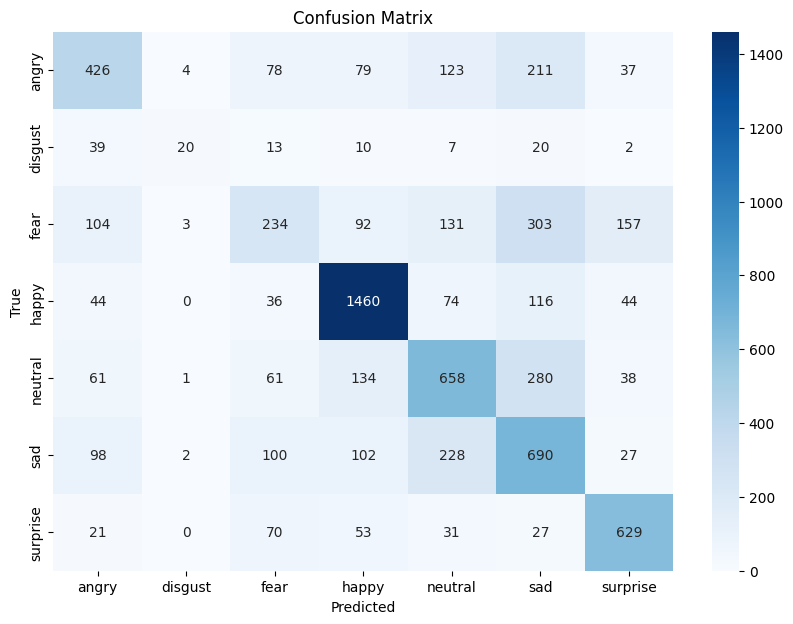

(0.5735580941766508,
 0.5663773118485251,
 0.5735580941766508,
 0.5617984229526164)

In [43]:
evaluate_model(model, test_loader)

In [44]:
# 9. Save the Model
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model saved as '{filename}'")

save_model(model, 'emotion_CNN_model.pth')

Model saved as 'emotion_CNN_model.pth'


In [ ]:
# 10. Load the Model for Inference
model = EmotionCNN()
model.load_state_dict(torch.load('emotion_CNN_model.pth'))
model.eval()  # Set to evaluation mode

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [51]:
# 11. Visualize Some Test Results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def visualize_predictions(test_loader, num_images=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0), cmap='gray')
        plt.title(f'True: {train_dataset.classes[labels[i]]}\nPred: {train_dataset.classes[preds[i]]}')
        plt.axis('off')

    plt.show()

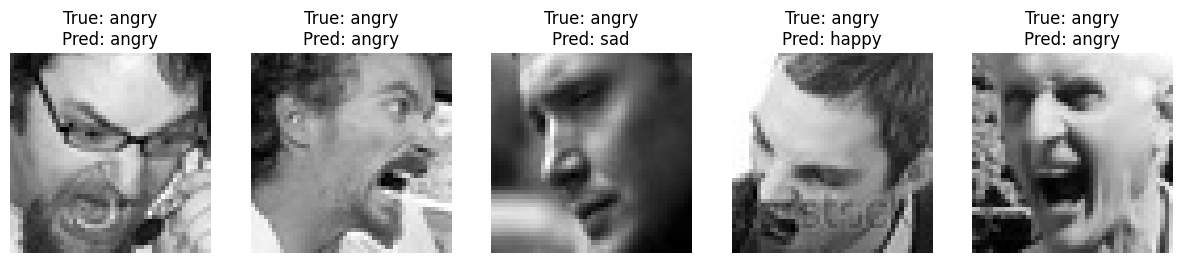

In [52]:
# 12. Visualize Predictions
visualize_predictions(test_loader)